Danny's dataset ztf-1a has 3,18,818 systems and light curves in three bands: r,g and i. But when we put the following constrains:
1. System has 2 images only
2. System has over 200 datapoints in light curves in the three bands (r,g,i)
3. Time delay $dt>=10$ days and $0.5<= \mu2/\mu1 <= 2.0$

we have only 433 systems. By visually looking into the light curves of these systems we tested our methods on the following systems which have good looking light curves. 

Here we apply our fitting method based on **template 1 (log-normal) + crossing statistics up to 4th order + stretch** on Danny's dataset (ztf-1a).

In this notebook, **we run longer MCMC chains (using emcee): (most having steps=100,000; burn=15,000).** 
Note that, in this notebook, work on the same systems as in "Applying_Danny_short.ipynb"

In [24]:
%reset -f

In [25]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
plt.rcParams['figure.figsize'] = [12, 8]

In [26]:
import pandas as pd
datapath="/home/users/satadru/lensed_supernovae/data"
fin=datapath+'/ztf-1a.h5'
df1I=pd.read_hdf(fin, 'image')

In [27]:
import sys
def get_mu_dt(sysno):
    print("="*80)
    mu=np.array((df1I[df1I['sysno']==sysn])['mu']);dt=np.array((df1I[df1I['sysno']==sysn])['td'])
    print(df1I[df1I['sysno']==sysn])
    if(len(mu)!=2):
        print("Not a 2-image system...")
        sys.exit()
    
    idx=np.argsort(dt);dt=dt[idx]; mu=mu[idx]
    dt1=dt[1]-dt[0]; mu1=np.abs(mu[1]/mu[0])
    print("\nRelative magnification, mu=",mu1, "time delay dt=",dt1,"\n","="*80)
    return mu1,dt1

In [28]:
#template 1: equ(19)
def mod(x,dt,t0,n,xk,s,c0,c1,c2,c3,c4):    
    mean=n;sig=xk;
    x=x-t0;
    xmax=np.amax(x)
    x=x-dt;
    x=x-s*x;
    #idx=np.where(x<1e-15)[0]
    x[x<1e-15]=1e-16
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    #fx[idx]=0.0
    
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

In [29]:
#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 1.0, True, 0.4,2.5),('dt1',30.0, True,0.0,60.0) ,('t0',0.0, False,0.0,60.0));

p.add_many(('nr', 1.0, True, 0.1,10.0), ('tkr', 0.1, True, 0.0,3.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0.1, True, None,None) ,('c4r', 0.1,True, None,None))

p.add_many(('ng', 1.0, True, 0.1,10.0), ('tkg', 0.1, True, 0.0,3.0),('sg', 0.01,True, 0.0,0.99))#, ;
p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0.1,True, None,None) ,('c4g', 0.1,True, None,None))

p.add_many(('nni', 1.0, True, 0.0,10.0), ('tki', 0.1, True, 0.0,3.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0.1, True, None,None),('c4i', 0.1, True, None,None))

#p.add_many(('nz', 1.0, True, 0.1,10.0), ('tkz', 0.10, True, 0.0,3.0),('sz', 0.01,True, 0.0,0.99));
#p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None),
#          ('c3z', 0, False, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod(tr,0,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod(tr,v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod(tg,0,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod(tg,v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod(ti,0,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],v['c4i'])
            +v['mu1']*mod(ti,v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],v['c4i'])-fi)/sigfi;
    
    #B4=(mod(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)
            #+v['mu1']*mod(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

In [30]:
import corner
#print(res2.params.valuesdict().values())

def plot_contour(sample,mu_des,dt_des):
    emcee_plot = corner.corner(sample.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0.000001,
                           truths=list([mu_des,dt_des]))
    plt.show(emcee_plot)

In [31]:
def plot_func(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=data
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    #print(len(mle_soln))
    t0m=0.0;
    [mum,dtm,
     nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm,
     ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm,
     nim,tkim,sim,c0im,c1im,c2im,c3im,c4im,
     lnm]=mle_soln;
    
    #print(mle_soln)
    #print("g-band: ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm=",ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod(tr,0,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Ps2r=mum*mod(tr,dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Psr=Ps1r+Ps2r

    
    Ps1g=mod(tg,0,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Ps2g=mum*mod(tg,dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Psg=Ps1g+Ps2g

    
    Ps1i=mod(ti,0,t0m,nim,tkim,sim,c0im,c1im,c2im,c3im,c4im)
    Ps2i=mum*mod(ti,dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,c3im,c4im)
    Psi=Ps1i+Ps2i
 

    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 1')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r: %s ponits"%(len(tr))) #data
    plt.plot(tr, Psr, c="r")

    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g: %s ponits"%(len(tg))) #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b: %s ponits"%(len(ti))) #data
    plt.plot(ti, Psi, c="b")

    plt.legend(loc=0)
    plt.show()
    
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2);

    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("\nChi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi)
    print("data points::: r-band:",len(tr)," g-band:",len(tg)," i-band:",len(ti))
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")

    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    

    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")

    
    plt.legend(loc=0)
    plt.show()


In [32]:
def read_data(sysn):
    inp_path='../read_data/ztf-1a/'
    bands=['ztfr','ztfg','ztfi']
    fileN='ztf-1a_stackedflux_sysn%s_band_'%(sysn)

    fileNr=inp_path+fileN+bands[0];print(fileNr)
    fileNg=inp_path+fileN+bands[1];print(fileNg)
    fileNi=inp_path+fileN+bands[2];print(fileNi)

    tr,fr,sigfr=np.loadtxt(fileNr,usecols=[0,1,2], unpack=True)
    tg,fg,sigfg=np.loadtxt(fileNg,usecols=[0,1,2], unpack=True)
    ti,fi,sigfi=np.loadtxt(fileNi,usecols=[0,1,2], unpack=True)

    t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
    t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
    t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs);

    # we substract a fixed time, it should not have any effect on the pystan results
    tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 
    t_max=t_max-t_min; t_min=0.0;

    c=['r','g','b']
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]),label=r"r-band: %s points"%(len(tr)))
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]),label=r"g-band: %s points"%(len(tg)))
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]),label=r"i-band: %s points"%(len(ti)))
    plt.legend(loc=0)
    plt.show()

    mu_des,dt_des=get_mu_dt(sysn)
    return [tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]

In [33]:
def fitting(sysn,step,burn,thin,nwalker):
    res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=burn, steps=step, thin=thin, 
                         nwalkers=nwalker,params=p, is_weighted=False,seed=20145)
    lmfit.report_fit(res.params,show_correl=False,min_correl=0.9);
    plot_contour(res, mu_des,dt_des)
    plot_func(res)
    return res;

In [34]:
sys_no_list_full1=[14485178,25739652,30168511,30484845,31999299,33603471,36126318,37790873,39087310,
                  40221141,44994746,46459738,47725481,51127319,53345196,55281814,59593933,61550746]

sys_no_list_full2=[62250655,70776641,70861347,71488663,76226169,76277223,77272711,81741581,82320026, 93507840, 94866642
                   ,95598133,96069612, 96640307,98361511]

print(len(sys_no_list_full1),len(sys_no_list_full2))

18 15


**Below we apply template 1 (equ(19)) + stretch + 4th order crossing statistics on the following systems from Danny's datasets**

In [35]:
sys_no_list=[40221141,44994746,46459738,47725481,51127319,53345196,55281814,59593933];
Nsys=len(sys_no_list);
print("Total no. of systems to be studied=",Nsys)
results=np.zeros(Nsys,dtype=object)
i=0;

Total no. of systems to be studied= 8


In [36]:
step=100000; burn=15000; nwalker=150; thin=3;


Starting i=0, SystemNo=40221141 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn40221141_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn40221141_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn40221141_band_ztfi


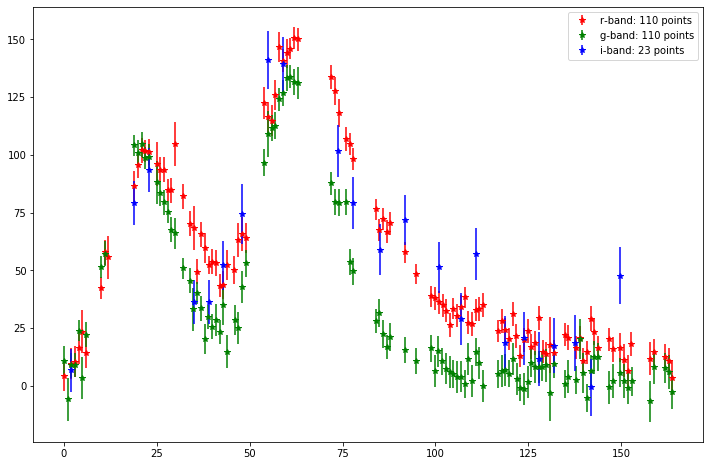

          td         x         y        mu     sysno  imno
0   0.000000  2.079878 -1.065848  2.157818  40221141     0
1  42.099531 -1.159171 -0.211248 -2.834009  40221141     1

Relative magnification, mu= 1.3133678212732556 time delay dt= 42.099531222904446 


100%|██████████| 200000/200000 [2:03:28<00:00, 27.00it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 26 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4000;
tau: [16435.95945535  7874.70055431 19310.87010665 17252.84059929
  5753.52360176 24774.96582046 24002.94940076 23191.31040247
 24046.81888292 24421.87401961 23239.58019248 21715.98315882
  5396.78445306 24331.71580397 24027.11359774 22684.37703212
 23667.79502749 24801.78575844 19498.12730376 16402.94748353
 15814.18009372 24271.85680823 24007.20344052 25171.28101254
 23909.3690953  22291.49469978   125.28312204]
[[Variables]]
    mu1:        1.79066134 +/- 0.72075183 (40.25%) (init = 1)
    dt1:        1.45657946 +/- 3.65068011 (250.63%) (init = 30)
    t0:         0 (fixed)
    nr:         2.74904461 +/- 0.70429789 (25.62%) (init = 1)
    tkr:        1.32641079 +/- 0.30514960 (23.01%) (init = 0.1)
    sr:         0.97699668 +/- 0.05419132 (5.55%) (init = 0.01)
    c0r:        32279.1431 +/- 339989.468 (1053.28%) (init = 1)
  

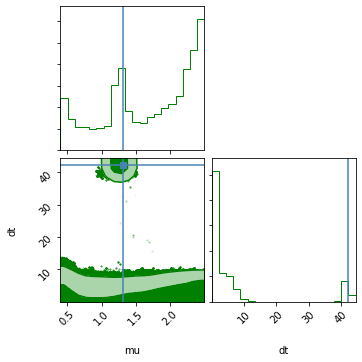


Maximum likelihood Estimation
-----------------------------


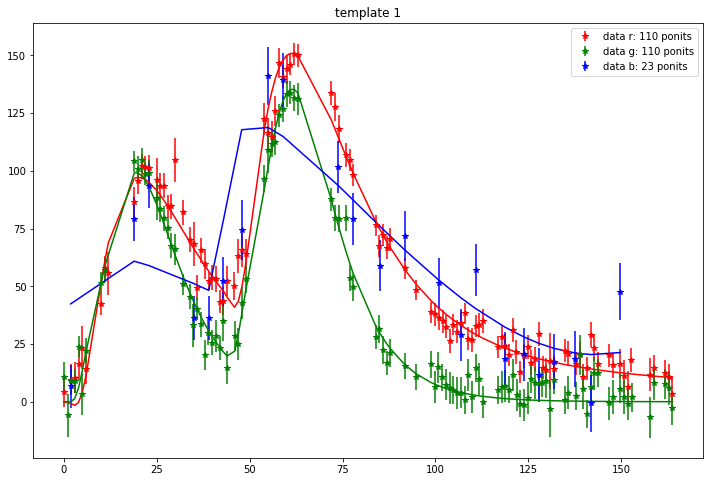

Maximum liklihood: mu= 1.3261295881096402 dt= 42.31411432396501

Chi^2 r= 148.65571277939858 Chi^2 g= 102.58071245521973 Chi^2 i= 78.78895722126144
data points::: r-band: 110  g-band: 110  i-band: 23


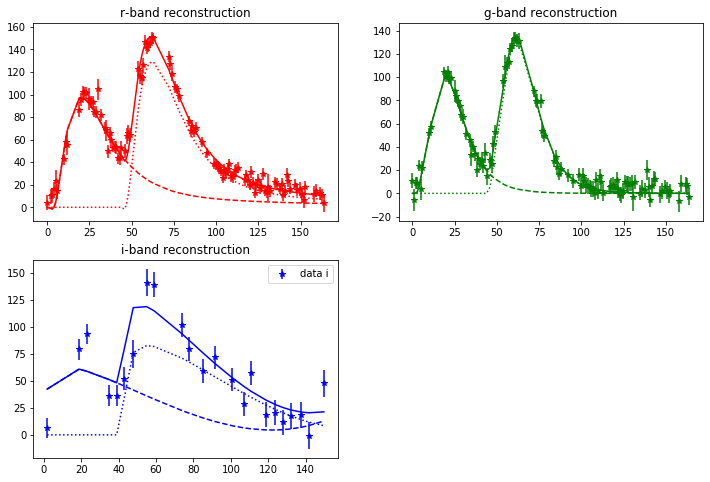

In [37]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,200000,20000,thin,nwalker)
i=i+1


Starting i=1, SystemNo=44994746 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn44994746_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn44994746_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn44994746_band_ztfi


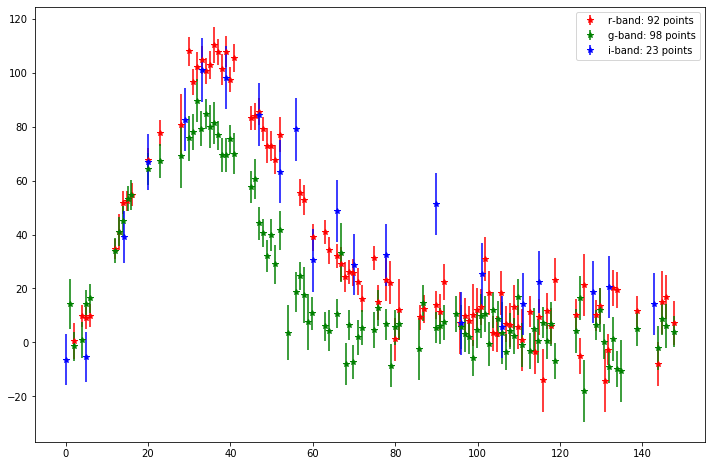

          td         x         y        mu     sysno  imno
0   0.000000  0.485639  1.247925  2.960797  44994746     0
1  16.663513 -0.603189 -0.466314 -3.326374  44994746     1

Relative magnification, mu= 1.1234724868234462 time delay dt= 16.66351324175443 


100%|██████████| 100000/100000 [1:20:24<00:00, 20.73it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 6883.71018756  2481.75215604  4538.82461721  4674.37077466
  4550.10771595 11340.66287436 11019.57533604 11037.72694054
 10936.64134788 11715.33937532  9497.51051994  3992.49308998
  7569.16580862 11866.16735305 10946.99533602 11773.5928027
 10932.8594929  11118.61038949  6233.78425109  7505.72108729
  8114.8228419  11902.24363432 11136.12503975 11857.66590096
 10804.70279824 11431.74762522  7564.57387221]
[[Variables]]
    mu1:        0.85874408 +/- 0.15436834 (17.98%) (init = 1)
    dt1:        16.6368931 +/- 0.86850928 (5.22%) (init = 30)
    t0:         0 (fixed)
    nr:         1.47218041 +/- 0.59958274 (40.73%) (init = 1)
    tkr:        0.60961289 +/- 0.07761358 (12.73%) (init = 0.1)
    sr:         0.88918607 +/- 0.06735919 (7.58%) (init = 0.01)
    c0r:        15003.4334 +/- 32684.8440 (217.85%) (init = 1)
    c1

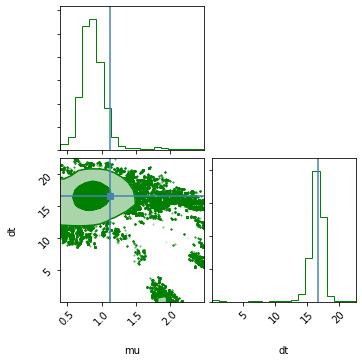


Maximum likelihood Estimation
-----------------------------


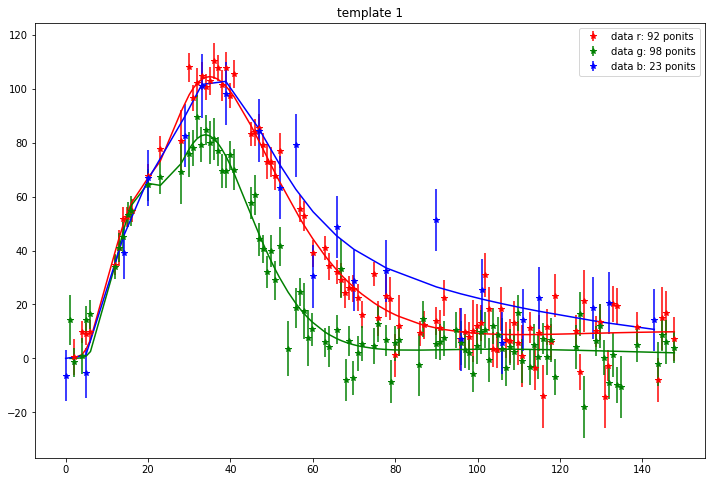

Maximum liklihood: mu= 0.8597179931246192 dt= 17.179226035214647

Chi^2 r= 96.74535681441232 Chi^2 g= 94.84436398476322 Chi^2 i= 19.25234652155732
data points::: r-band: 92  g-band: 98  i-band: 23


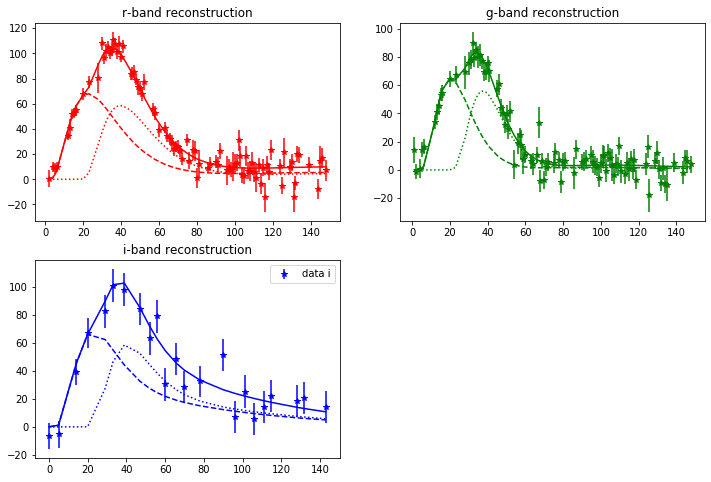

In [38]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=2, SystemNo=46459738 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn46459738_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn46459738_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn46459738_band_ztfi


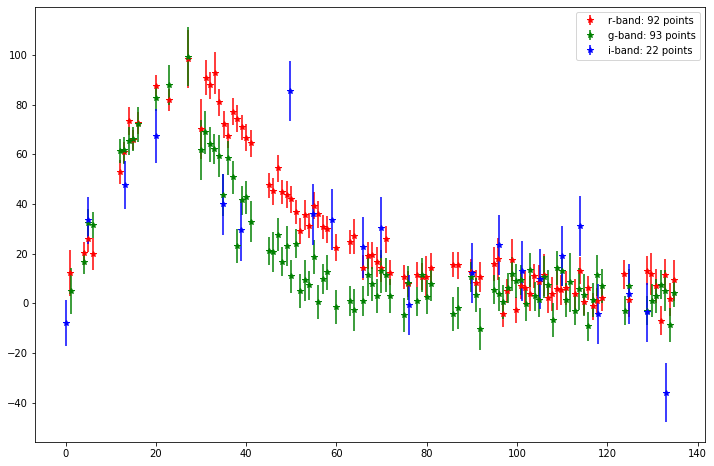

          td         x         y        mu     sysno  imno
0   0.000000 -1.956442  0.234326  1.703017  46459738     0
1  15.402554  0.400205  0.091977 -0.895088  46459738     1

Relative magnification, mu= 0.5255899957414523 time delay dt= 15.402554103716941 


100%|██████████| 100000/100000 [1:06:32<00:00, 25.05it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 7712.99823858  4714.45596035  8557.95294303  6458.21686471
  7345.7395653  10737.60050367 10833.73556047 10660.15381318
 10600.93392676 11048.05016839  8917.581326    6652.42343007
  8229.71839121 10423.74233494 11126.88613816 10377.93603689
 11163.18716103 10934.29566417  9574.06243456  9599.87729986
  9323.96859379 11063.67628107 11149.92122453 10754.21452225
 10418.91436086 10568.95974575  9751.24970084]
[[Variables]]
    mu1:        0.71370147 +/- 0.15443026 (21.64%) (init = 1)
    dt1:        12.6772040 +/- 1.55454996 (12.26%) (init = 30)
    t0:         0 (fixed)
    nr:         2.01803777 +/- 0.86444038 (42.84%) (init = 1)
    tkr:        0.74857813 +/- 0.09296266 (12.42%) (init = 0.1)
    sr:         0.71079074 +/- 0.20420304 (28.73%) (init = 0.01)
    c0r:        526.987806 +/- 12661.1242 (2402.55%) (init = 1)
  

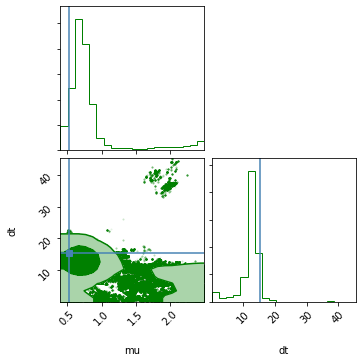


Maximum likelihood Estimation
-----------------------------


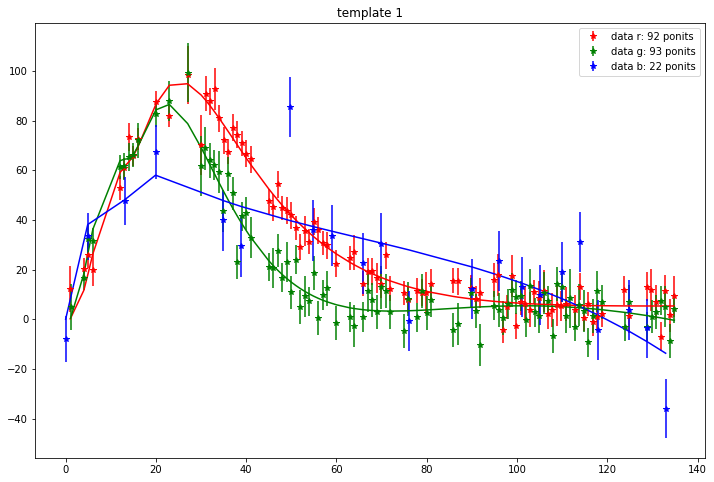

Maximum liklihood: mu= 0.6749266887215644 dt= 12.803319468317579

Chi^2 r= 81.85091469655633 Chi^2 g= 74.15145438718724 Chi^2 i= 35.047788639275005
data points::: r-band: 92  g-band: 93  i-band: 22


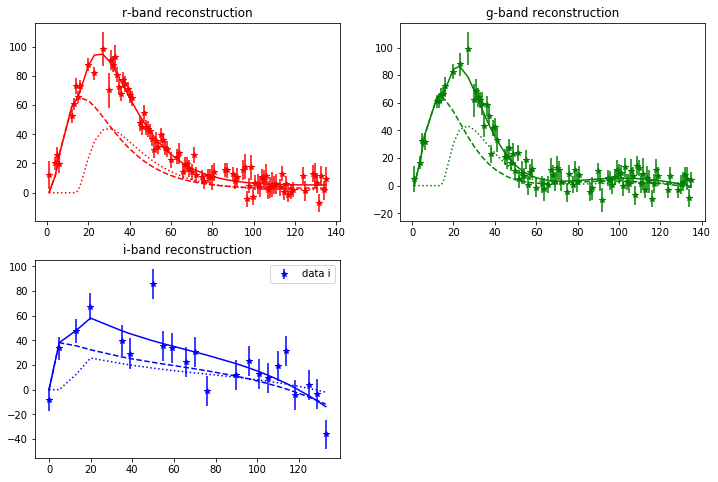

In [39]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=3, SystemNo=47725481 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfi


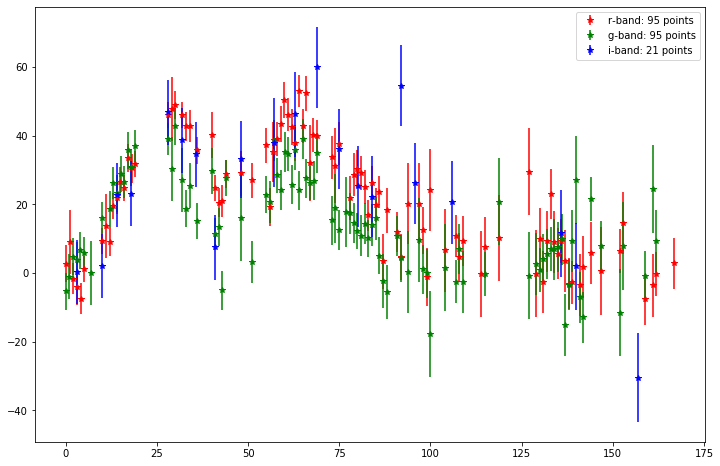

          td         x         y        mu     sysno  imno
0   0.000000 -0.981259  2.403174  1.569831  47725481     0
1  39.800098  0.448137 -0.396369 -1.188744  47725481     1

Relative magnification, mu= 0.757243240555537 time delay dt= 39.800098300372284 


100%|██████████| 100000/100000 [1:11:46<00:00, 23.22it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 5026.5908217   3973.07293054  8796.46654581  4338.37479907
  7368.00677475 11259.18251932 10786.59921616 11005.58108062
 10831.00558477 11112.71020956  8948.45424522  6557.34796036
  7730.87475394 10906.14754657 10658.94164625 10920.39641312
 10912.45446783 11040.22811207 10793.41254411 10243.46706021
  8943.57612302 11157.4499528  11316.74999125 11072.39167272
 11408.96437735 11812.96810693  6020.40977446]
[[Variables]]
    mu1:        0.77193205 +/- 0.07510020 (9.73%) (init = 1)
    dt1:        39.9488547 +/- 1.08119156 (2.71%) (init = 30)
    t0:         0 (fixed)
    nr:         2.04148486 +/- 0.92065360 (45.10%) (init = 1)
    tkr:        0.49575017 +/- 0.08541645 (17.23%) (init = 0.1)
    sr:         0.78739581 +/- 0.18189763 (23.10%) (init = 0.01)
    c0r:        3888.92006 +/- 36695.1938 (943.58%) (init = 1)
    c

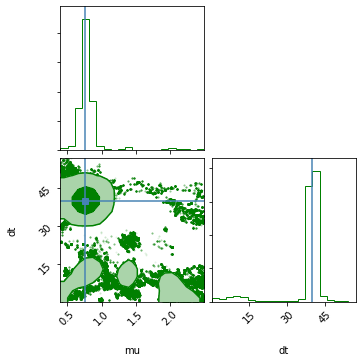


Maximum likelihood Estimation
-----------------------------


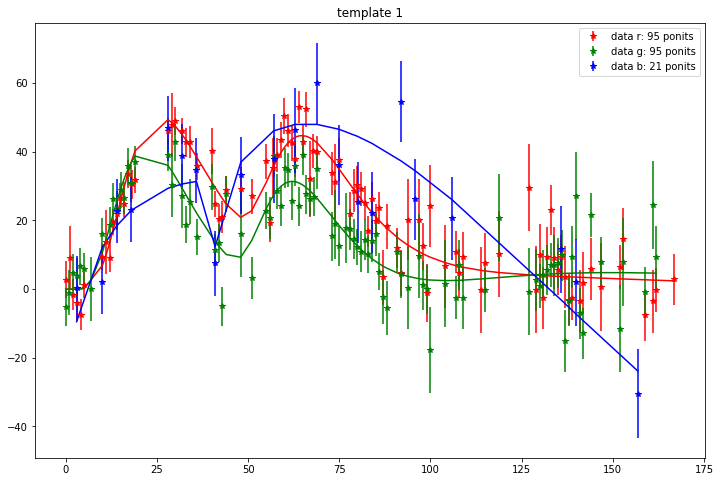

Maximum liklihood: mu= 0.7652569651458818 dt= 40.14616919029715

Chi^2 r= 88.47532263088476 Chi^2 g= 108.7401391716401 Chi^2 i= 19.818046386195736
data points::: r-band: 95  g-band: 95  i-band: 21


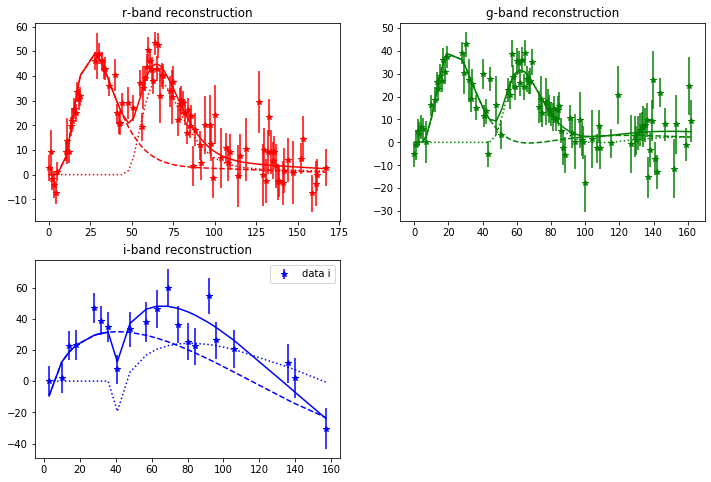

In [40]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=4, SystemNo=51127319 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn51127319_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn51127319_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn51127319_band_ztfi


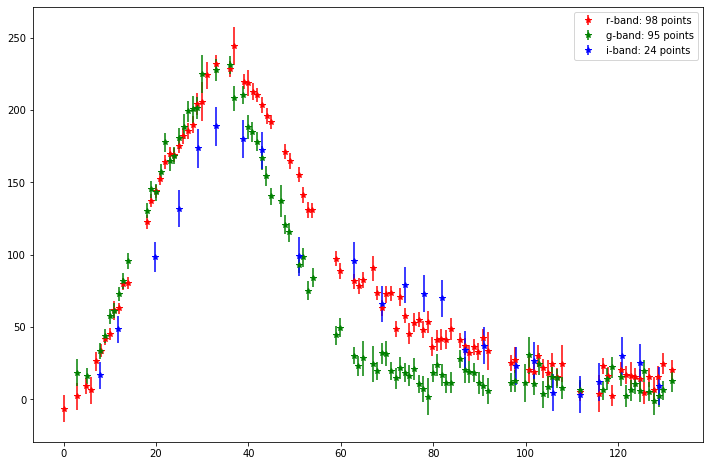

          td         x         y        mu     sysno  imno
0   0.000000 -2.581172 -2.287536  1.932921  51127319     0
1  15.585945  0.289097  1.407014 -2.064381  51127319     1

Relative magnification, mu= 1.0680110469797486 time delay dt= 15.58594525310361 


100%|██████████| 100000/100000 [1:25:33<00:00, 19.48it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 23 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 2773.31331606   853.51142536  7253.48712723   455.46914511
  1003.6061118  10619.58410339 10693.96574024 10948.30775829
 10698.91771569 11438.99557841  6071.41210102  5783.19775025
  1571.06874652 11024.50682702 11188.75803733 10847.32414528
 11156.18945777 11077.60373497  9848.86830932  7014.58461221
  9007.15186504 11113.7175774  11240.32588024 11066.02236509
 11196.09608764 10797.49644532  9777.52126517]
[[Variables]]
    mu1:        0.91961416 +/- 0.05877712 (6.39%) (init = 1)
    dt1:        15.1821780 +/- 0.40986263 (2.70%) (init = 30)
    t0:         0 (fixed)
    nr:         0.64257678 +/- 0.31215790 (48.58%) (init = 1)
    tkr:        0.58401038 +/- 0.02390165 (4.09%) (init = 0.1)
    sr:         0.94474327 +/- 0.01630060 (1.73%) (init = 0.01)
    c0r:        7363.87443 +/- 101829.070 (1382.82%) (init = 1)
    c1

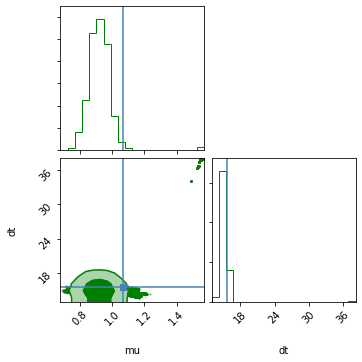


Maximum likelihood Estimation
-----------------------------


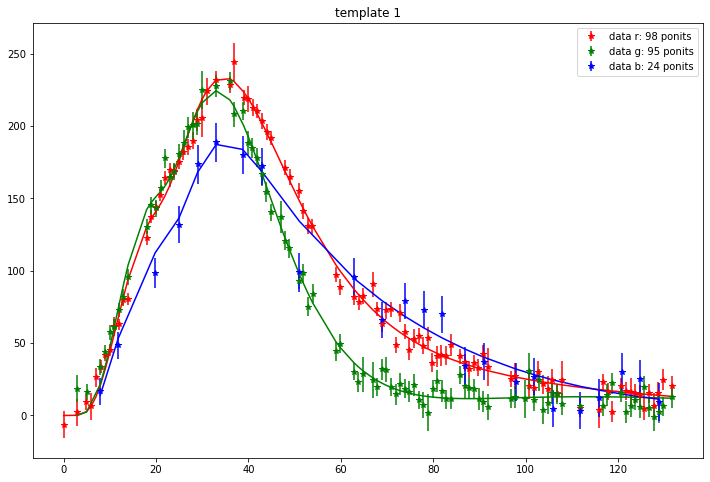

Maximum liklihood: mu= 0.9228626099092446 dt= 15.680034476750548

Chi^2 r= 127.88037995478871 Chi^2 g= 109.96490796529022 Chi^2 i= 22.01677870923446
data points::: r-band: 98  g-band: 95  i-band: 24


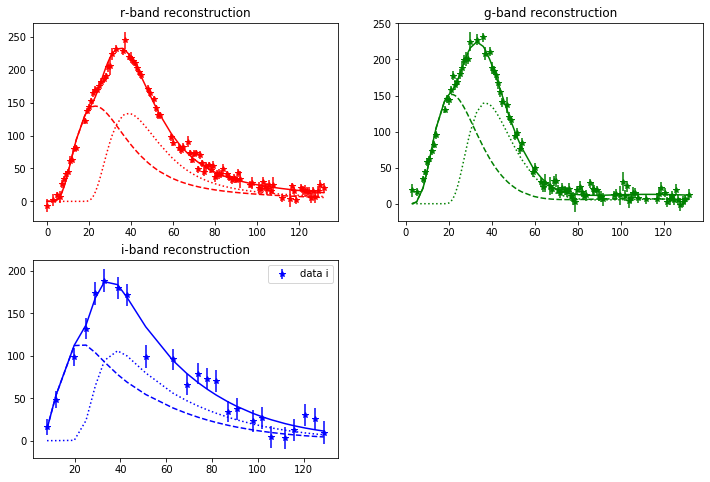

In [41]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=5, SystemNo=53345196 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn53345196_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn53345196_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn53345196_band_ztfi


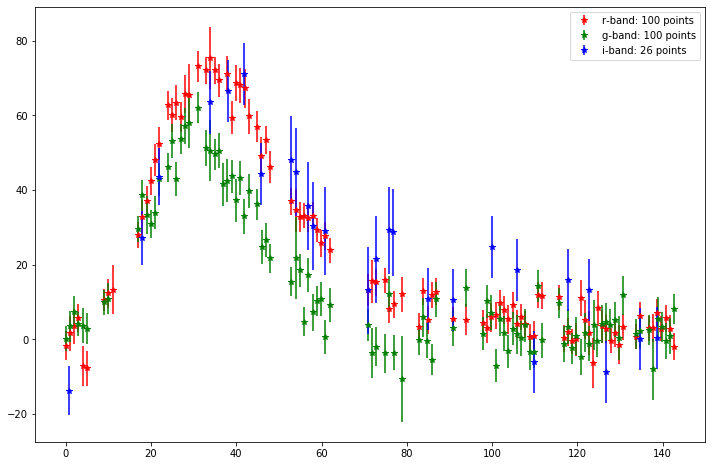

          td         x         y        mu     sysno  imno
0   0.000000  0.060143 -1.500517  2.213087  53345196     0
1  11.320505  0.060448  0.547088 -1.960205  53345196     1

Relative magnification, mu= 0.8857334969728631 time delay dt= 11.320504501316087 


100%|██████████| 100000/100000 [1:16:17<00:00, 21.85it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 8225.65950082  4169.83642383  6133.48322789  5072.60826674
  7727.64323236 10585.53526394 10698.15271654 10847.65347107
 11007.50839966 11043.14909901  8349.84166324  7085.53126954
  8600.4753801  10743.12865619 10584.59823549 10721.11245896
 10527.10203362 11125.22679532  8521.05510558  7711.09647133
  8285.55848792 10907.17035186 11116.80361691 10833.70889457
 10989.68083544 10568.26039592  8851.40436406]
[[Variables]]
    mu1:        1.11421396 +/- 0.28071379 (25.19%) (init = 1)
    dt1:        12.7227590 +/- 1.10157755 (8.66%) (init = 30)
    t0:         0 (fixed)
    nr:         2.61222264 +/- 0.66426552 (25.43%) (init = 1)
    tkr:        0.57924164 +/- 0.06564237 (11.33%) (init = 0.1)
    sr:         0.63699162 +/- 0.22949019 (36.03%) (init = 0.01)
    c0r:        1690.37486 +/- 22161.5190 (1311.04%) (init = 1)
   

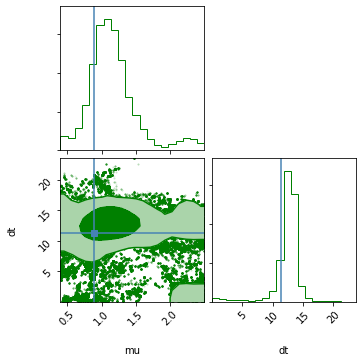


Maximum likelihood Estimation
-----------------------------


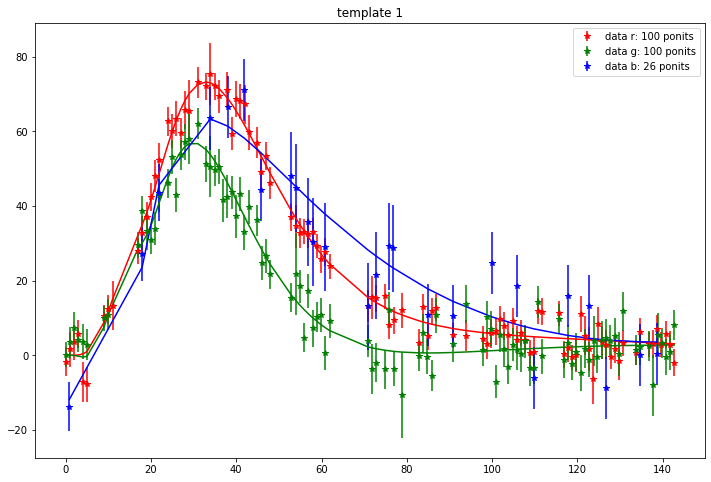

Maximum liklihood: mu= 1.1415958194376963 dt= 12.60649596784388

Chi^2 r= 74.52863940301499 Chi^2 g= 103.67289946813695 Chi^2 i= 22.083533003578253
data points::: r-band: 100  g-band: 100  i-band: 26


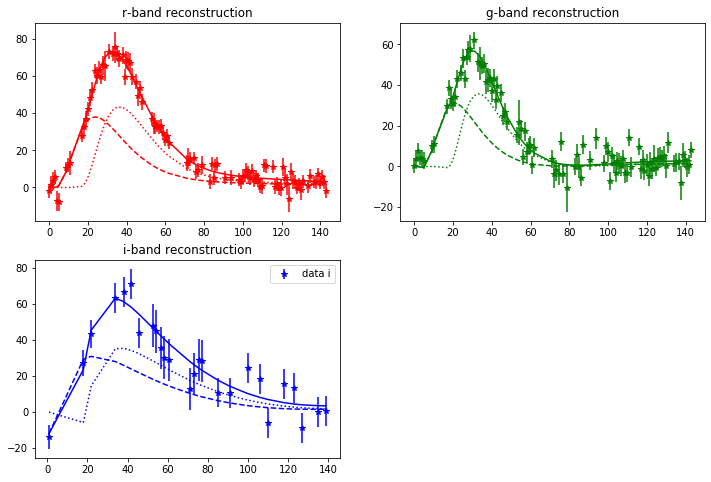

In [42]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=6, SystemNo=55281814 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn55281814_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn55281814_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn55281814_band_ztfi


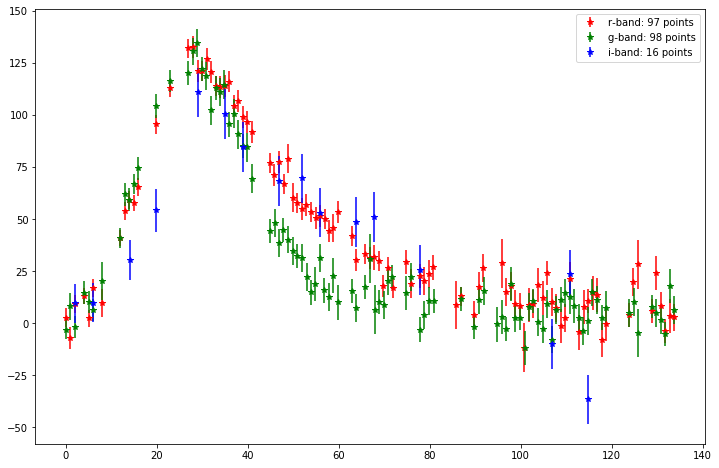

          td         x         y        mu     sysno  imno
0   0.000000 -1.609916  0.830515  1.676768  55281814     0
1  12.289364  0.339892 -0.092139 -0.868874  55281814     1

Relative magnification, mu= 0.5181841482288516 time delay dt= 12.289363803365912 


100%|██████████| 100000/100000 [1:11:53<00:00, 23.18it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 26 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 8486.06542893  3280.03093301  6534.15528202  3461.68142685
  1307.24175432 10782.18338186 11198.46534944 11262.66972082
 11119.11819218 11406.74215467  5690.81778863  4690.01337888
  8314.7307071  11579.79610572 11087.44454    11189.84908593
 10919.35733521 11608.00256231  8940.44143889  9237.97064715
  8593.82151609 11000.2373237  11440.83400267 11068.02163019
 11076.87097367 11612.06953556  8205.22270416]
[[Variables]]
    mu1:        1.21213230 +/- 0.26416349 (21.79%) (init = 1)
    dt1:        11.1261833 +/- 0.98238722 (8.83%) (init = 30)
    t0:         0 (fixed)
    nr:         0.75485650 +/- 0.44707597 (59.23%) (init = 1)
    tkr:        0.64966948 +/- 0.05657355 (8.71%) (init = 0.1)
    sr:         0.92599075 +/- 0.03335400 (3.60%) (init = 0.01)
    c0r:       -1661.79325 +/- 14779.0649 (889.34%) (init = 1)
    c1

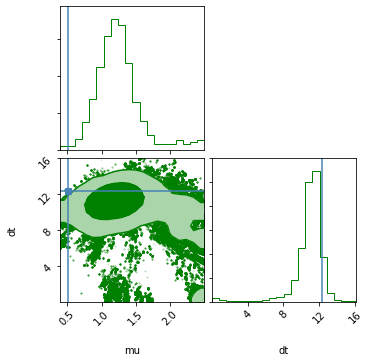


Maximum likelihood Estimation
-----------------------------


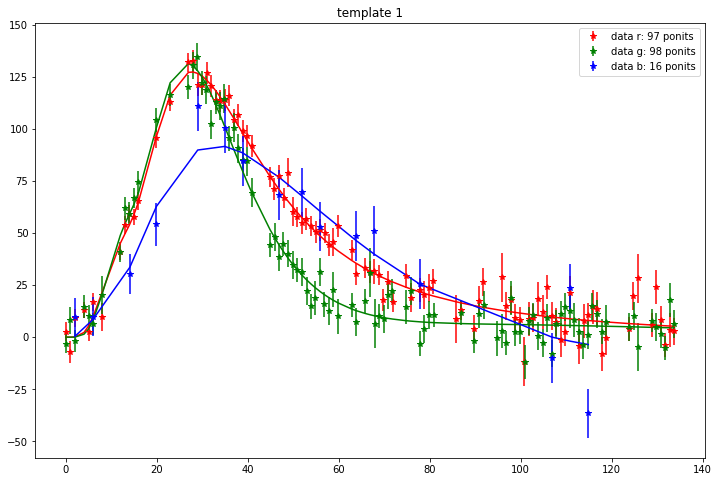

Maximum liklihood: mu= 1.289571688867023 dt= 10.977818697424688

Chi^2 r= 111.16799792882912 Chi^2 g= 111.6948998613332 Chi^2 i= 20.672826243756276
data points::: r-band: 97  g-band: 98  i-band: 16


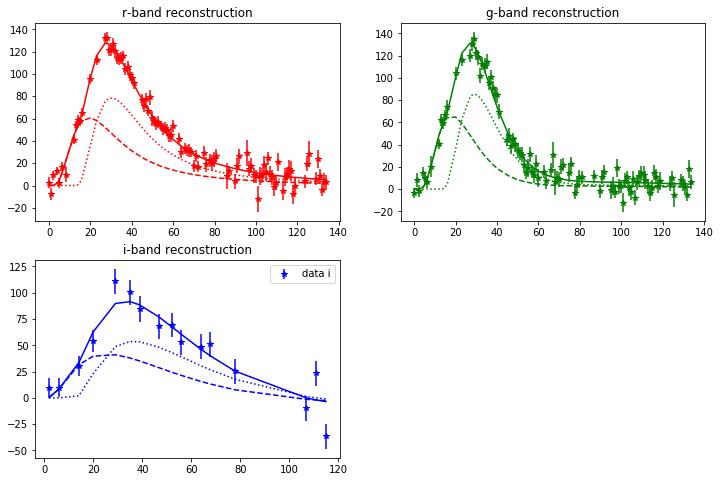

In [43]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=7, SystemNo=59593933 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn59593933_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn59593933_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn59593933_band_ztfi


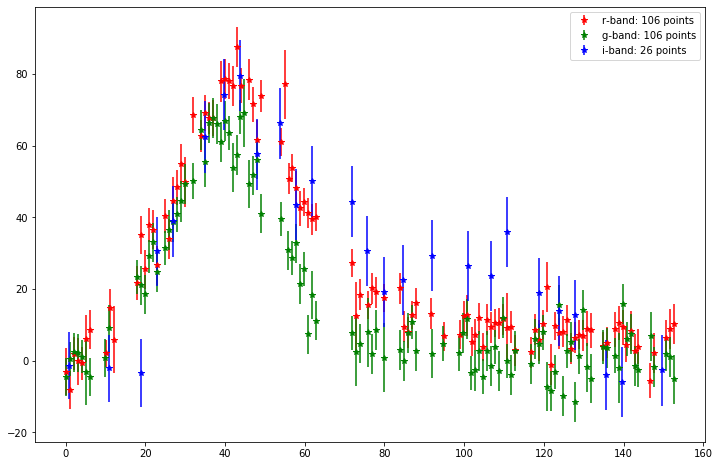

         td         x         y        mu     sysno  imno
0   0.00000  0.417686 -0.503390  1.747223  59593933     0
1  18.16256 -0.163767  0.143435 -3.359332  59593933     1

Relative magnification, mu= 1.9226694870444088 time delay dt= 18.162559807771114 


100%|██████████| 100000/100000 [1:22:21<00:00, 20.24it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 25 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 9448.53478372  3940.88428865  8267.74134682  1720.36026438
   868.47425156 11102.33255666 11685.86332758 11088.30444493
 11632.39245037 11398.21561552  7465.95591287  6516.20881766
  4433.34192241 10968.53485317 11855.2867082  11076.23985763
 11843.86287485 11098.44422676  8880.31582558  8350.68401249
  8939.42667605 11883.57442373 11979.01860704 11807.32516901
 11979.53853149 11490.82527064  6801.01158833]
[[Variables]]
    mu1:        1.56630543 +/- 0.27873409 (17.80%) (init = 1)
    dt1:        16.5661316 +/- 1.19746240 (7.23%) (init = 30)
    t0:         0 (fixed)
    nr:         1.26727269 +/- 0.47904039 (37.80%) (init = 1)
    tkr:        0.54814043 +/- 0.04676293 (8.53%) (init = 0.1)
    sr:         0.92217960 +/- 0.02440320 (2.65%) (init = 0.01)
    c0r:        14663.9462 +/- 72736.5230 (496.02%) (init = 1)
    c1

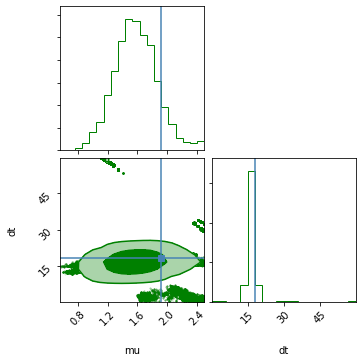


Maximum likelihood Estimation
-----------------------------


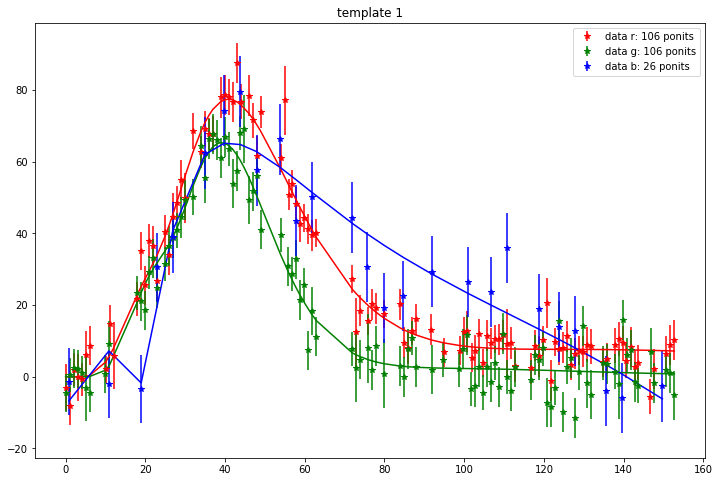

Maximum liklihood: mu= 1.4243471544143826 dt= 15.477504031601834

Chi^2 r= 83.99894935630778 Chi^2 g= 94.02840337554301 Chi^2 i= 18.90430051330926
data points::: r-band: 106  g-band: 106  i-band: 26


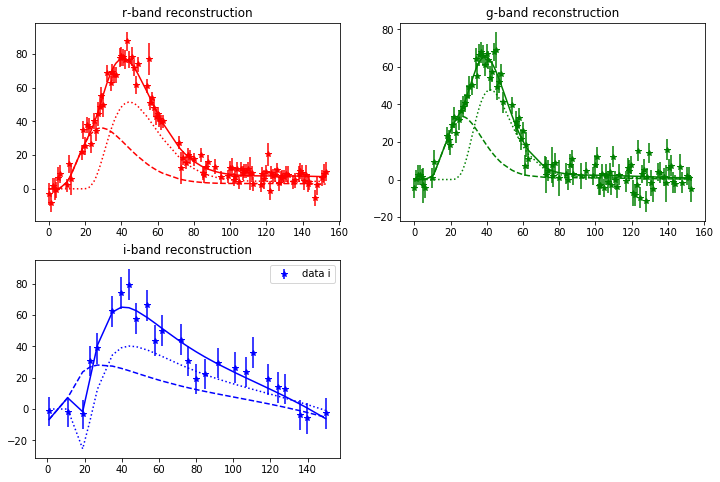

In [44]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting special, SystemNo=47725481 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfi


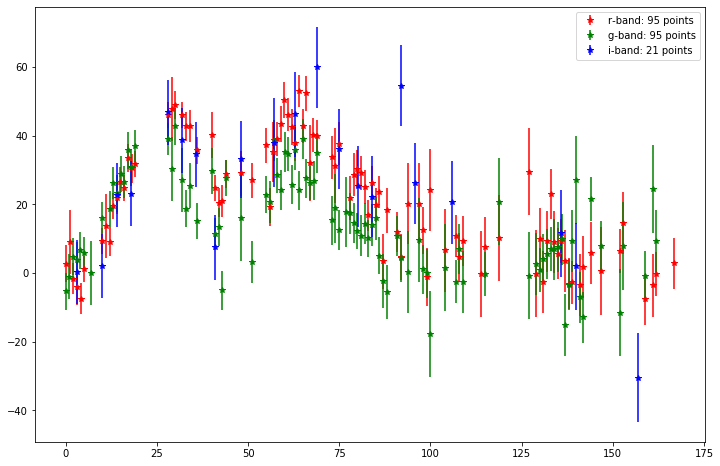

          td         x         y        mu     sysno  imno
0   0.000000 -0.981259  2.403174  1.569831  47725481     0
1  39.800098  0.448137 -0.396369 -1.188744  47725481     1

Relative magnification, mu= 0.757243240555537 time delay dt= 39.800098300372284 


100%|██████████| 100000/100000 [1:11:12<00:00, 23.41it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 5026.5908217   3973.07293054  8796.46654581  4338.37479907
  7368.00677475 11259.18251932 10786.59921616 11005.58108062
 10831.00558477 11112.71020956  8948.45424522  6557.34796036
  7730.87475394 10906.14754657 10658.94164625 10920.39641312
 10912.45446783 11040.22811207 10793.41254411 10243.46706021
  8943.57612302 11157.4499528  11316.74999125 11072.39167272
 11408.96437735 11812.96810693  6020.40977446]
[[Variables]]
    mu1:        0.77193205 +/- 0.07510020 (9.73%) (init = 1)
    dt1:        39.9488547 +/- 1.08119156 (2.71%) (init = 30)
    t0:         0 (fixed)
    nr:         2.04148486 +/- 0.92065360 (45.10%) (init = 1)
    tkr:        0.49575017 +/- 0.08541645 (17.23%) (init = 0.1)
    sr:         0.78739581 +/- 0.18189763 (23.10%) (init = 0.01)
    c0r:        3888.92006 +/- 36695.1938 (943.58%) (init = 1)
    c

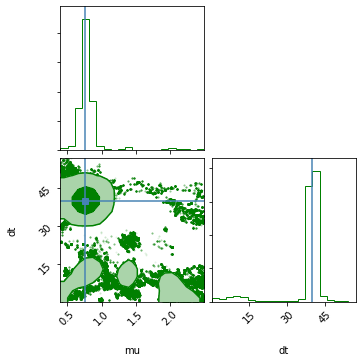


Maximum likelihood Estimation
-----------------------------


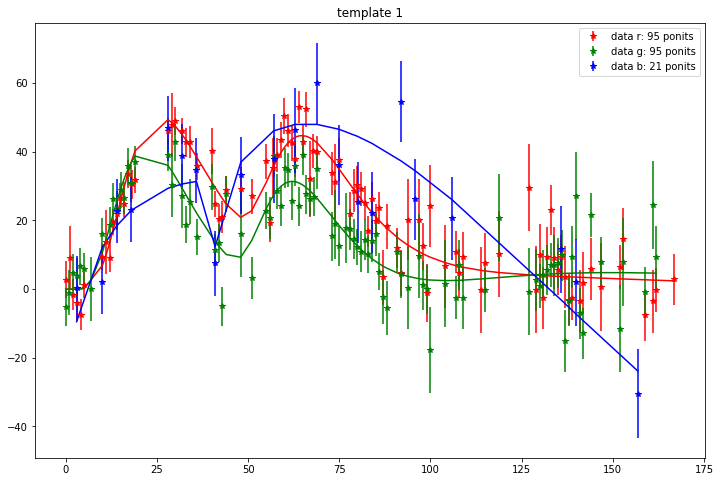

Maximum liklihood: mu= 0.7652569651458818 dt= 40.14616919029715

Chi^2 r= 88.47532263088476 Chi^2 g= 108.7401391716401 Chi^2 i= 19.818046386195736
data points::: r-band: 95  g-band: 95  i-band: 21


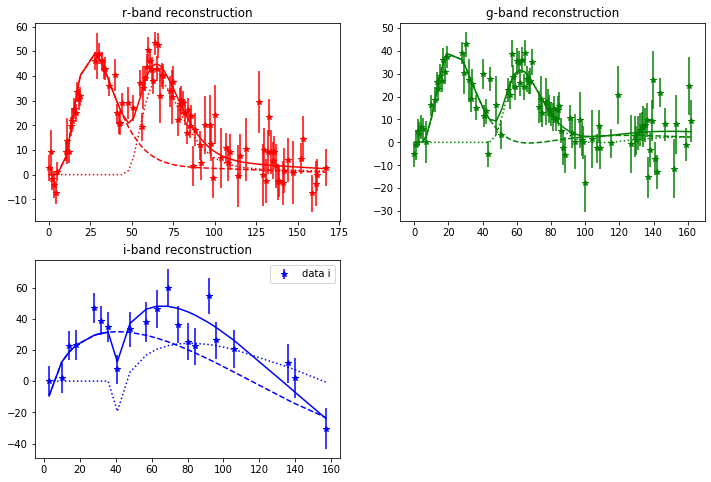

In [45]:
#Starting i=1, SystemNo=47725481

sysn=47725481
print("\nStarting special, SystemNo=%s \n"%(sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
res_special=fitting(sysn,step,burn,thin,nwalker)


Starting special, SystemNo=36126318 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn36126318_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn36126318_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn36126318_band_ztfi


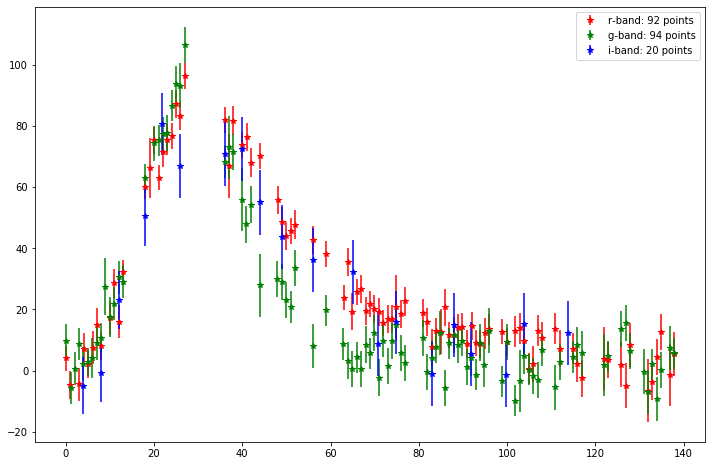

          td         x         y        mu     sysno  imno
0   0.000000  0.093277  1.009812  1.754933  36126318     0
1  10.520587 -0.073127 -0.216610 -1.053575  36126318     1

Relative magnification, mu= 0.6003505788399078 time delay dt= 10.520586892987547 


100%|██████████| 200000/200000 [2:25:07<00:00, 22.97it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4000;
tau: [18537.57834758  8999.93314565 18262.82771106 11504.39500113
  8888.78672895 22774.83422393 23179.85488551 23262.0975101
 23217.40981359 22938.20058375 17908.16132023  9477.92312949
 18463.05539868 23588.64132596 23083.72151191 23536.67997217
 22818.09869382 23385.04479715 17949.44336325 17734.6948405
 17658.74421626 23279.197712   23100.92737047 23183.15869175
 22833.6103318  22663.72119266 13999.40679379]
[[Variables]]
    mu1:        1.13394305 +/- 0.51009021 (44.98%) (init = 1)
    dt1:        10.1673297 +/- 1.08013657 (10.62%) (init = 30)
    t0:         0 (fixed)
    nr:         1.23198332 +/- 0.57851403 (46.96%) (init = 1)
    tkr:        0.63170186 +/- 0.06356502 (10.06%) (init = 0.1)
    sr:         0.88771997 +/- 0.07423707 (8.36%) (init = 0.01)
    c0r:       -2004.72472 +/- 24340.2684 (1214.15%) (init = 1)
    c

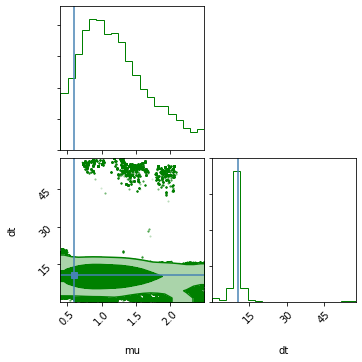


Maximum likelihood Estimation
-----------------------------


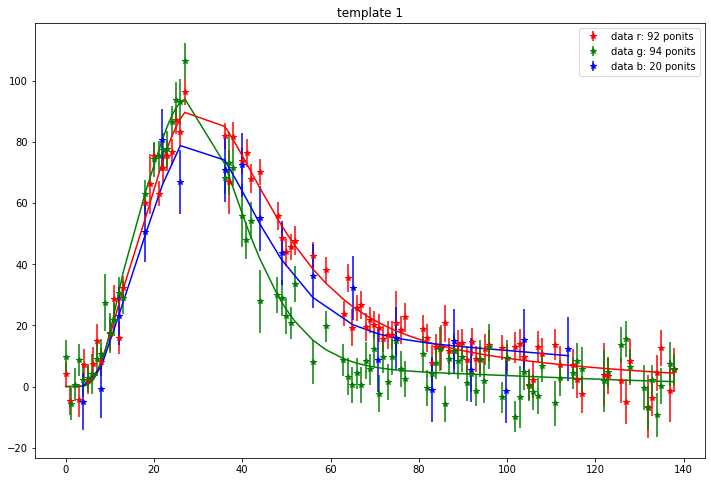

Maximum liklihood: mu= 0.7614940293621977 dt= 11.030933570309118

Chi^2 r= 76.86077980186623 Chi^2 g= 92.26685240991998 Chi^2 i= 11.992082813587169
data points::: r-band: 92  g-band: 94  i-band: 20


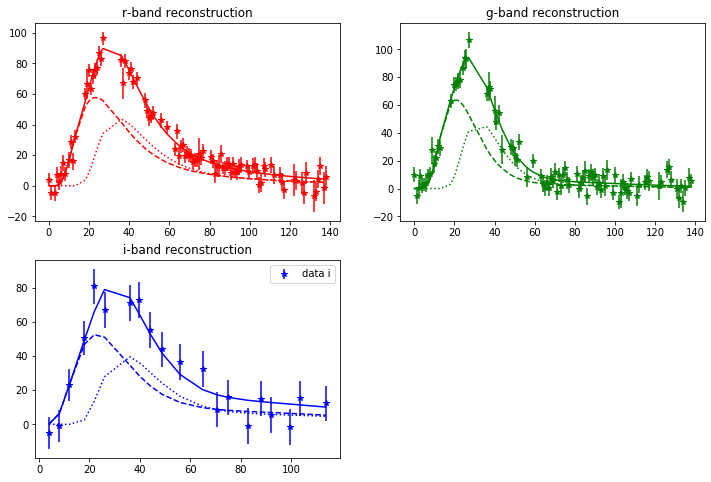

In [46]:
sysn=36126318
print("\nStarting special, SystemNo=%s \n"%(sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
res_special=fitting(sysn,200000,burn,thin,nwalker)


Starting special, SystemNo=47725481 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn47725481_band_ztfi


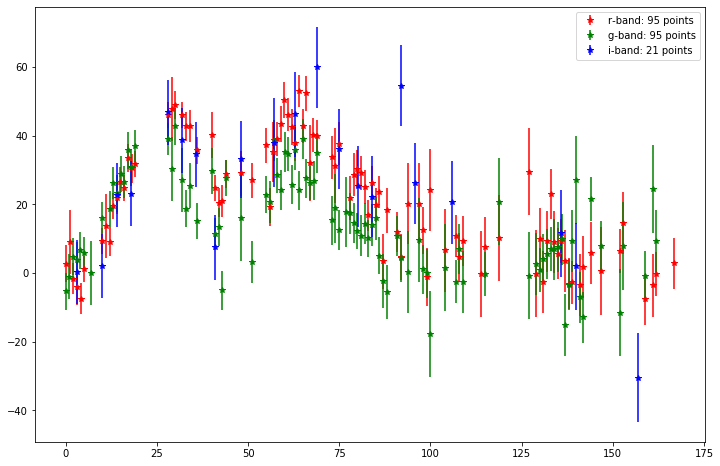

          td         x         y        mu     sysno  imno
0   0.000000 -0.981259  2.403174  1.569831  47725481     0
1  39.800098  0.448137 -0.396369 -1.188744  47725481     1

Relative magnification, mu= 0.757243240555537 time delay dt= 39.800098300372284 


100%|██████████| 150000/150000 [1:46:03<00:00, 23.57it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3000;
tau: [ 8291.70780677  6531.7107551  13564.2122581   6775.99174067
 12045.18696314 16431.68808545 16157.26543858 16312.57067731
 16276.51579601 16037.80323742 12816.32657795 11858.14470623
 12161.03051889 16593.99576668 15879.1155871  16472.38004007
 15795.65615774 16148.19004105 16860.82634192 14788.97885358
 13544.39823507 16624.88765273 16327.69337087 16368.67011086
 16768.26341307 17609.60300238  9989.5122034 ]
[[Variables]]
    mu1:        0.77317272 +/- 0.07498410 (9.70%) (init = 1)
    dt1:        39.8962943 +/- 1.06720328 (2.67%) (init = 30)
    t0:         0 (fixed)
    nr:         2.04822821 +/- 0.86516851 (42.24%) (init = 1)
    tkr:        0.49608518 +/- 0.08839588 (17.82%) (init = 0.1)
    sr:         0.77995293 +/- 0.20177033 (25.87%) (init = 0.01)
    c0r:        6233.32873 +/- 75369.3776 (1209.14%) (init = 1)
    

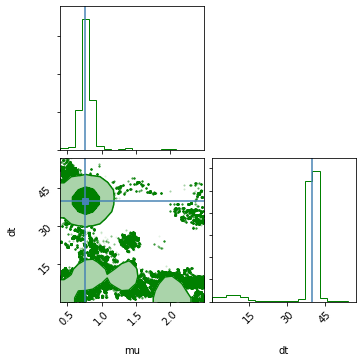


Maximum likelihood Estimation
-----------------------------


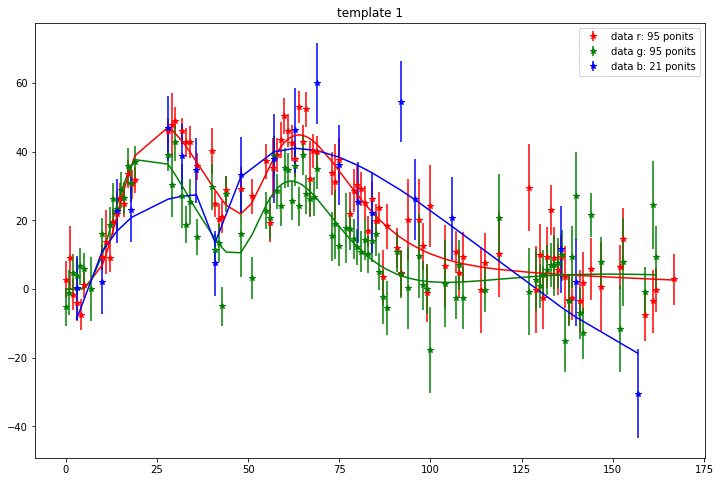

Maximum liklihood: mu= 0.781611586749678 dt= 39.52717049459923

Chi^2 r= 84.45547201209216 Chi^2 g= 109.24543120947959 Chi^2 i= 22.433929869903277
data points::: r-band: 95  g-band: 95  i-band: 21


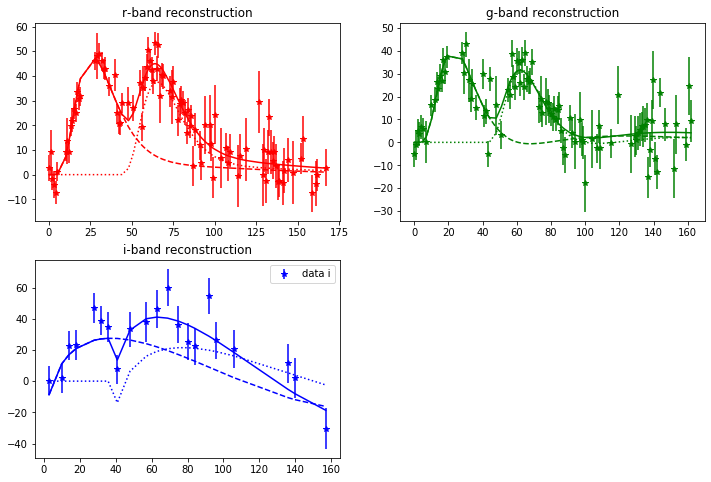

In [47]:
sysn=47725481
print("\nStarting special, SystemNo=%s \n"%(sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
res_special3=fitting(sysn,150000,20000,thin,nwalker)
